In [1]:
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import cartopy.crs as crs
import matplotlib.ticker as mticker
import cartopy.feature as cfeature
from cartopy.feature import NaturalEarthFeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from mpl_toolkits.axes_grid1 import make_axes_locatable
from wrf import getvar, interplevel, to_np, get_basemap, ll_to_xy,latlon_coords,latlon_coords, smooth2d,get_cartopy, cartopy_xlim, cartopy_ylim
import pandas as pd
from netCDF4 import Dataset
import netCDF4
import h5py as h5
import csv
from scipy import stats
import seaborn as sns
from metpy.plots import SkewT
from metpy.units import pandas_dataframe_to_unit_arrays, units

In [3]:
#QNA1CLOUD carried by cloud
#QNA1RAIN carried by rain
#QNA1ICE carried by ice
#QNA1SNOW carried by snow
#QNA1GRAUPEL carried by graupel

In [29]:
# Open the NetCDF file
filename = "440ERA5SEEDED"
ncfile2 = Dataset(filename)
ncfile = h5.File(filename, 'r')
ds = netCDF4.Dataset(filename)

# GETTING DATA
slp = getvar(ncfile2, "slp")
snow = ncfile2['QSNOW'][:].squeeze()
cloud = ncfile2['QCLOUD'][:].squeeze()
ice = ncfile2['QICE'][:].squeeze()
rain = ncfile2['QRAIN'][:].squeeze()
grop = ncfile2['QGRAUP'][:].squeeze()
total_ice = snow + ice + grop
seed_material = ncfile2['QNA1'][:].squeeze()
seed = np.max(seed_material, axis = 0)
# Open the NetCDF file
filename = "440ERA5S"
ncfile2 = Dataset(filename)
ncfile = h5.File(filename, 'r')
ds = netCDF4.Dataset(filename)

# GETTING DATA
slp = getvar(ncfile2, "slp")
snow = ncfile2['QSNOW'][:].squeeze()
cloud = ncfile2['QCLOUD'][:].squeeze()
ice = ncfile2['QICE'][:].squeeze()
rain = ncfile2['QRAIN'][:].squeeze()
grop = ncfile2['QGRAUP'][:].squeeze()
total_ice2 = snow + ice + grop

total_ice = total_ice - total_ice2

# BASE CALCULATIONS

P = ncfile2['P'][:].squeeze()
PB = ncfile2['PB'][:].squeeze()
PHB = ncfile2['PHB'][:].squeeze()
PH = ncfile2['PH'][:].squeeze()
lat = ncfile2['XLAT'][:].squeeze()
lon = ncfile2['XLONG'][:].squeeze()
Tv = getvar(ncfile2, 'tv', units = 'K', meta = False)
PRES = wrf_pres(P,PB)/100

THETA = ncfile2['T'][:].squeeze()
THETA = wrf_theta(THETA)
TEMP = wrf_temp(THETA,PRES).squeeze()
HEIGHT = wrf_height(PH,PHB)
PRES = PRES*100
Density = PRES/(287.16*Tv)

delta_z = np.zeros((80,600,900))

In [30]:
#HEIGHT AGL AND DELTA Z
ter = getvar(ncfile2, "ter", units = 'm', meta= False)
z=0
height_agl = HEIGHT
while z < 80:
    height_agl[z,:,:] = height_agl[z,0:600,0:900]-ter[0:600,0:900]
    z = z + 1
    
z=0
while z < 80:
    delta_z[z,:,:] = height_agl[z+1,:,:] - height_agl[z,:,:]
    z = z + 1

#IWP CALCULATIONS
IWP = Density[:,:,:]*total_ice[:,:,:]*delta_z[:,:,:]
total = np.zeros((600,900))
z=0
while z < 80:
    adder = IWP[z,:,:]
    total = total + adder
    z = z + 1
total_IWP = total
total_IWP.squeeze()

masked_array(
  data=[[0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, ..., -6.200329573134514e-10,
         -1.09272600919696e-09, 0.0],
        [0.0, 0.0, 0.0, ..., -3.541945086801632e-09,
         -5.127537019197062e-09, 0.0],
        ...,
        [0.0, 0.0, 0.0, ..., 3.996359356324538e-06,
         1.4446054346500617e-06, 0.0],
        [0.0, 0.0, 0.0, ..., 1.6886167848819897e-06, 8.9393280040986e-07,
         0.0],
        [0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0]],
  mask=[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],
  fill_value=1e+20)

In [38]:
# Open the NetCDF file
filename = "440ERA5SEEDED"
ncfile2 = Dataset(filename)
cloud_carried = ncfile2['QNA1CLOUD'][:].squeeze()
rain_carried = ncfile2['QNA1RAIN'][:].squeeze()
ice_carried = ncfile2['QNA1ICE'][:].squeeze()
snow_carried = ncfile2['QNA1SNOW'][:].squeeze()
graupel_carried = ncfile2['QNA1GRAUPEL'][:].squeeze()
lat = ncfile2['XLAT'][:].squeeze()
lon = ncfile2['XLONG'][:].squeeze()
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.io.img_tiles as cimgt
request = cimgt.StamenTerrain()   # very responsive
crg = request.crs
z = 0
u = 0
while z< 600:
    while u < 900:
        new = crg.transform_point(lon[z,u], lat[z,u], crs.Geodetic())
        lon[z,u] = new[0]
        lat[z,u] = new[1]
        u = u + 1
    z = z + 1
    u = 0

/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/cheyenne/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: The StamenTerrain class was deprecated in v0.17. Please use Stamen('terrain-background') instead.
  from ipykernel import kernelapp as app


In [41]:
cloud_carried_max = np.max(cloud_carried, axis = 0)
ice_carried_max = np.max(ice_carried, axis = 0) + np.max(snow_carried, axis = 0) + np.max(graupel_carried, axis = 0)+cloud_carried_max

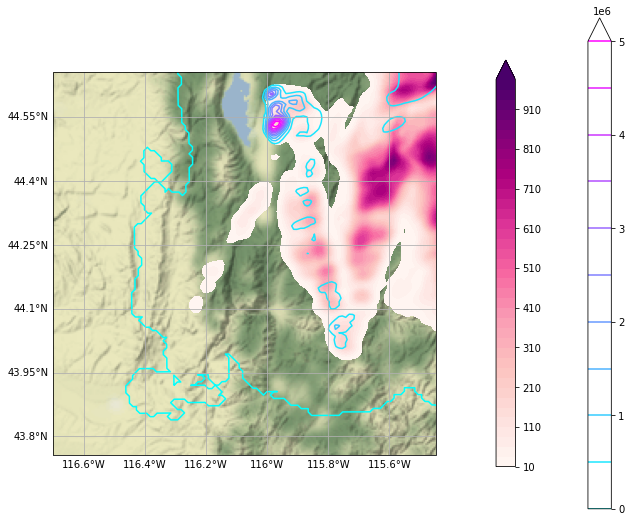

In [42]:
def make_map(projection=ccrs.PlateCarree()):
    fig, ax = plt.subplots(figsize=(10, 10),
                           subplot_kw=dict(projection=projection))
    gl = ax.gridlines(draw_labels=True)
    gl.xlabels_top = gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    return fig, ax

fig, ax = make_map(projection = crg)

# specify map extent here
lonmin, lonmax = -116.70062, -115.44735
latmin, latmax = 43.756786, 44.655064

LL = crg.transform_point(lonmin, latmin, ccrs.Geodetic())
UR = crg.transform_point(lonmax, latmax, ccrs.Geodetic())
EW = UR[0] - LL[0]
SN = UR[1] - LL[1]
side = max(EW,SN)
mid_x, mid_y = LL[0]+EW/2.0, LL[1]+SN/2.0  #center location

rlevs = np.arange(10000,720000,50000)
extent = [mid_x-side/2.0, mid_x+side/2.0, mid_y-side/2.0, mid_y+side/2.0]   # map coordinates, meters
ax.set_extent(extent, crs=crg)
ax.add_image(request, 8)
#cont = ax.contourf(lon[269:385,343:456], lat[269:385,343:456], cloud_carried_max[269:385,343:456], rlevs,cmap=get_cmap("RdPu"), extend = "max")
cont2 = ax.contour(lon[269:385,343:456], lat[269:385,343:456], ice_carried_max[269:385,343:456], 10,cmap=get_cmap("cool"), extend = "max")
cbr3 = plt.colorbar(cont2,fraction=0.0419, pad=0.13)
rlevs = np.arange(10,1000,25)

cont = ax.contourf(lon[269:385,343:456], lat[269:385,343:456], total_IWP[269:385,343:456]*1000, rlevs,cmap=get_cmap("RdPu"), extend = "max")
cbr3 = plt.colorbar(cont,fraction=0.0419, pad=0.13)
plt.savefig("450_INP.png")